# Семинар 4: "Методы оптимизации"

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации.

На семинаре реализуем и сравним методы:
<b>SGD, NAG, Adagrad, RMSProp</b>.



## Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

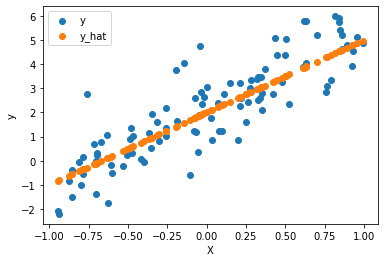

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

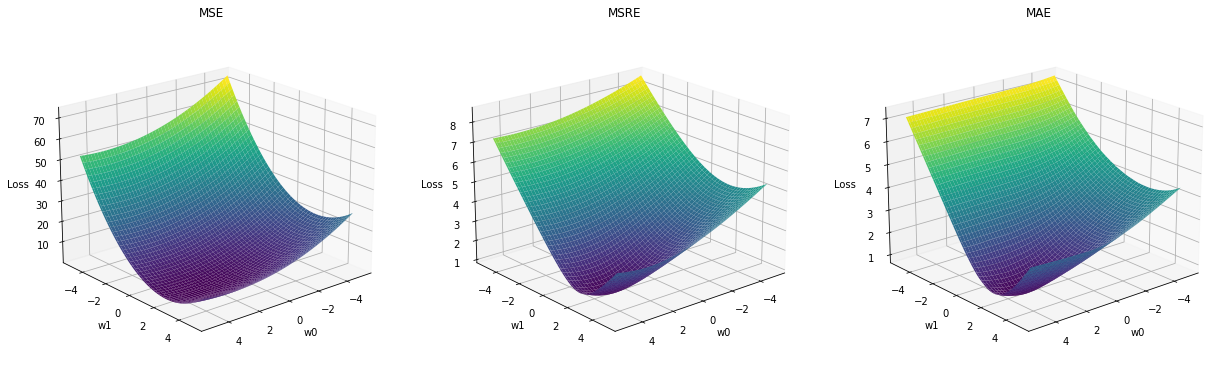

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуем методы SGD, NAG, Adagrad, RMSProp</i>:

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

### SGD
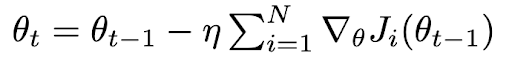

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is not None:
                    p -= self.lr * p.grad


### Nesterov accelerated gradient
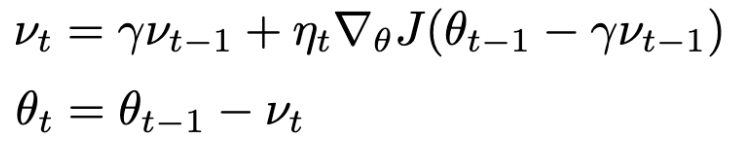

In [9]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    prev_momentum = self.momentum[i]
                    self.momentum = self.gamma * prev_momentum + self.lr * p.grad
                    p -= (1 + self.gamma) * self.momentum[i] - self.gamma * prev_momentum


### AdaGrad
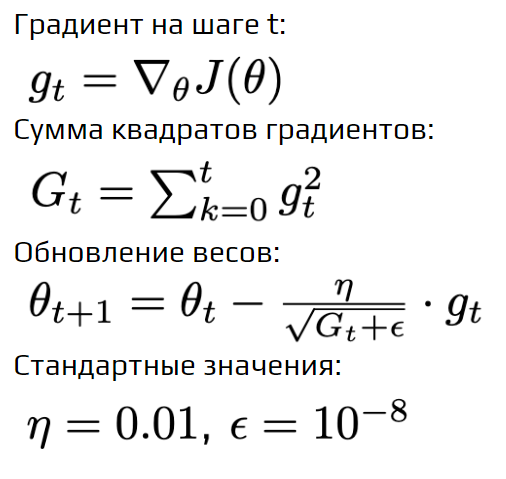

In [10]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)

        self.eta = eta
        self.epsilon = epsilon

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.G[i] += p.grad ** 2
                    p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### RMSProp

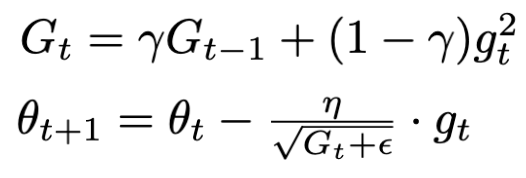

In [11]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)

        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)

                    p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad



In [20]:
class Momentum(Optimizer):
    def __init__(self, params, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma

        self.v = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.v[i] = self.gamma * self.v[i] + self.eta * p.grad

                    p -= self.v[i]

In [35]:
class AdaDelta(Optimizer):
    def __init__(self, params, epsilon=1e-6, gamma=0.9):
        super().__init__(params)

        self.epsilon = epsilon
        self.gamma = gamma

        self.prev = [torch.zeros(p.shape) for p in self.params]
        
        self.u = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]        

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.v[i] = self.gamma * self.v[i] + (1 - self.gamma) * (p.grad ** 2)
                    delta = ((self.u[i] + self.epsilon) ** 0.5) / ((self.v[i] + self.epsilon) ** 0.5) * p.grad
                    
                    self.u[i] = self.gamma * self.u[i] + (1 - self.gamma) * (delta ** 2)
                        
                    p -= delta


In [28]:
class Adam(Optimizer):
    def __init__(self, params, eta=1e-2, epsilon=1e-8, beta1=0.9, beta2=0.999):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 1

        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                    self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad ** 2)

                    p -= self.eta / ((self.v[i] / (1 - self.beta2 ** self.iter)) ** 0.5 + self.epsilon) * \
                        (self.m[i] / (1 - self.beta1 ** self.iter))
                    
        self.iter += 1

In [13]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaGrad, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [120]:
compare_optimizers(
    loss_animator,
    mse,
    [
#         ['SGD', SGD, {'lr': 1e-1}],
#         ['NAG', NAG, {'lr': 1e-1}],
#         ['AdaGrad', AdaGrad, {'eta': 1}],
#         ['RMSProp', RMSProp, {'eta': 1}],
       ['Momentum', Momentum, {'lr': 1e-1, 'gamma': 0.9}],
       ['Adam', Adam, {'eta': 1}],        
        ['AdaDelta', AdaDelta, {'gamma': 0.9, 'epsilon': 1e-4}],
    ],
    start_point=[-4, -4],
    num_iter=400
)

В качестве домашней работы вам необходимо будет реализовать и сравнить методы:
<b>Momentum, AdaDelta, Adam</b>.

Также вам будет предложено сравнить реализованные методы при обучении полносвязной и сверточной нейронных сетей на датасете MNIST.



In [44]:
import torch
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [46]:
mnist_dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor(), download=True)
print(mnist_dataset)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 10824507.79it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 4629153.69it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 4120838.15it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|█████████████████████████████████████| 4542/4542 [00:00<00:00, 8515.39it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [47]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

length of Train Datasets:  50000
length of Validation Datasets:  10000


In [50]:
import torch.nn as nn

input_size = 28 * 28
num_classes = 10


In [51]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

In [105]:
class MnistModelFC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, input_size * 2)
        self.fc2 = nn.Linear(input_size * 2, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.fc2(nn.functional.relu(self.fc1(xb)))
        return(out)
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return(loss)
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return({'val_loss':loss, 'val_acc': acc})
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
        
class MnistModelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3) 
        self.pool1 = nn.MaxPool2d(kernel_size=2) 
        self.conv2 = nn.Conv2d(3, 16, kernel_size=3) 
        self.pool2 = nn.MaxPool2d(kernel_size=2) 
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3) 
        self.fc = nn.Linear(2592, num_classes)
        
    
    def forward(self, xb):
        out = nn.functional.relu(self.conv1(xb))
        out = nn.functional.relu(self.pool1(out))
        out = nn.functional.relu(self.conv2(out))
        out = nn.functional.relu(self.conv3(out))
        out = self.fc(out.reshape((xb.shape[0], -1)))
        return(out)
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return(loss)
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return({'val_loss':loss, 'val_acc': acc})
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))        
        
    
model_fc = MnistModelFC()
model_cnn = MnistModelCNN()

In [61]:
from tqdm import tqdm

In [84]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return(model.validation_epoch_end(outputs))

def fit(epochs, args, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), **args)
    for epoch in range(epochs):
    
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [70]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

Text(0.5, 1.0, 'Accuracy Vs. No. of epochs')

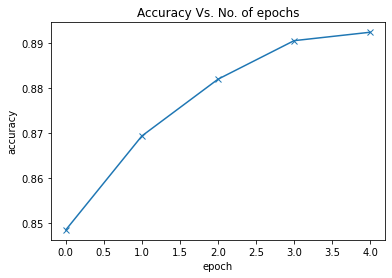

In [79]:
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')

In [118]:
hist = {}


for model_name, model_class in {
    "MnistModelFC": MnistModelFC,
    "MnistModelCNN": MnistModelCNN
}.items():
    for optim_name, (optim, args) in {
        'Momentum': (Momentum, {'lr': 1e-2, 'gamma': 0.9}),
        'Adam': (Adam, {'eta': 1e-2}),        
        'AdaDelta': (AdaDelta, {'gamma': 0.9, 'epsilon': 1e-4}),
    }.items():
        model = model_class()
        history = fit(10, args, model, train_loader, val_loader, optim)
        hist[model_name + "_" + optim_name] = history

100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 70.74it/s]


Epoch [0], val_loss: 0.3357, val_acc: 0.9060


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 66.50it/s]


Epoch [1], val_loss: 0.2713, val_acc: 0.9266


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 72.84it/s]


Epoch [2], val_loss: 0.2350, val_acc: 0.9390


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 70.03it/s]


Epoch [3], val_loss: 0.2096, val_acc: 0.9450


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 71.72it/s]


Epoch [4], val_loss: 0.1891, val_acc: 0.9501


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 74.60it/s]


Epoch [5], val_loss: 0.1736, val_acc: 0.9529


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 74.21it/s]


Epoch [6], val_loss: 0.1598, val_acc: 0.9576


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 71.23it/s]


Epoch [7], val_loss: 0.1480, val_acc: 0.9597


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 73.75it/s]


Epoch [8], val_loss: 0.1411, val_acc: 0.9618


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 73.60it/s]


Epoch [9], val_loss: 0.1329, val_acc: 0.9633


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 75.31it/s]


Epoch [0], val_loss: 0.1757, val_acc: 0.9536


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 71.78it/s]


Epoch [1], val_loss: 0.1417, val_acc: 0.9657


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 74.04it/s]


Epoch [2], val_loss: 0.1309, val_acc: 0.9685


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 75.62it/s]


Epoch [3], val_loss: 0.1594, val_acc: 0.9646


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 73.38it/s]


Epoch [4], val_loss: 0.1824, val_acc: 0.9616


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 75.25it/s]


Epoch [5], val_loss: 0.1637, val_acc: 0.9684


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 75.91it/s]


Epoch [6], val_loss: 0.1971, val_acc: 0.9664


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 73.80it/s]


Epoch [7], val_loss: 0.1963, val_acc: 0.9669


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 71.34it/s]


Epoch [8], val_loss: 0.2083, val_acc: 0.9675


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 67.52it/s]


Epoch [9], val_loss: 0.2338, val_acc: 0.9682


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 70.93it/s]


Epoch [0], val_loss: 0.1630, val_acc: 0.9558


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 71.98it/s]


Epoch [1], val_loss: 0.1136, val_acc: 0.9663


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 74.53it/s]


Epoch [2], val_loss: 0.0934, val_acc: 0.9742


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 73.36it/s]


Epoch [3], val_loss: 0.0907, val_acc: 0.9731


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 72.55it/s]


Epoch [4], val_loss: 0.0786, val_acc: 0.9785


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 71.31it/s]


Epoch [5], val_loss: 0.0830, val_acc: 0.9773


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 74.41it/s]


Epoch [6], val_loss: 0.0803, val_acc: 0.9787


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 75.65it/s]


Epoch [7], val_loss: 0.0824, val_acc: 0.9777


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 72.73it/s]


Epoch [8], val_loss: 0.0730, val_acc: 0.9806


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 74.27it/s]


Epoch [9], val_loss: 0.0748, val_acc: 0.9806


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 72.16it/s]


Epoch [0], val_loss: 0.1409, val_acc: 0.9589


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 69.41it/s]


Epoch [1], val_loss: 0.1040, val_acc: 0.9708


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 69.19it/s]


Epoch [2], val_loss: 0.0879, val_acc: 0.9768


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 64.06it/s]


Epoch [3], val_loss: 0.0808, val_acc: 0.9759


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 64.93it/s]


Epoch [4], val_loss: 0.0733, val_acc: 0.9792


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 61.64it/s]


Epoch [5], val_loss: 0.0653, val_acc: 0.9825


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 62.79it/s]


Epoch [6], val_loss: 0.0571, val_acc: 0.9841


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 63.07it/s]


Epoch [7], val_loss: 0.0613, val_acc: 0.9836


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 65.22it/s]


Epoch [8], val_loss: 0.0587, val_acc: 0.9845


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 65.26it/s]


Epoch [9], val_loss: 0.0593, val_acc: 0.9832


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 61.84it/s]


Epoch [0], val_loss: 0.1030, val_acc: 0.9688


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 65.40it/s]


Epoch [1], val_loss: 0.0837, val_acc: 0.9782


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 67.35it/s]


Epoch [2], val_loss: 0.0693, val_acc: 0.9791


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 61.48it/s]


Epoch [3], val_loss: 0.0657, val_acc: 0.9808


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 64.62it/s]


Epoch [4], val_loss: 0.0630, val_acc: 0.9816


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 64.62it/s]


Epoch [5], val_loss: 0.0935, val_acc: 0.9767


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 65.09it/s]


Epoch [6], val_loss: 0.0867, val_acc: 0.9770


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 62.55it/s]


Epoch [7], val_loss: 0.0729, val_acc: 0.9801


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 60.37it/s]


Epoch [8], val_loss: 0.0760, val_acc: 0.9828


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 64.05it/s]


Epoch [9], val_loss: 0.0767, val_acc: 0.9809


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 64.94it/s]


Epoch [0], val_loss: 0.0965, val_acc: 0.9740


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 59.25it/s]


Epoch [1], val_loss: 0.0680, val_acc: 0.9804


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 60.53it/s]


Epoch [2], val_loss: 0.0714, val_acc: 0.9798


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 63.57it/s]


Epoch [3], val_loss: 0.0745, val_acc: 0.9811


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 61.37it/s]


Epoch [4], val_loss: 0.0733, val_acc: 0.9819


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 62.91it/s]


Epoch [5], val_loss: 0.0742, val_acc: 0.9835


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 65.98it/s]


Epoch [6], val_loss: 0.0705, val_acc: 0.9827


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 62.67it/s]


Epoch [7], val_loss: 0.0740, val_acc: 0.9835


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 65.43it/s]


Epoch [8], val_loss: 0.0942, val_acc: 0.9821


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 63.95it/s]

Epoch [9], val_loss: 0.0756, val_acc: 0.9842


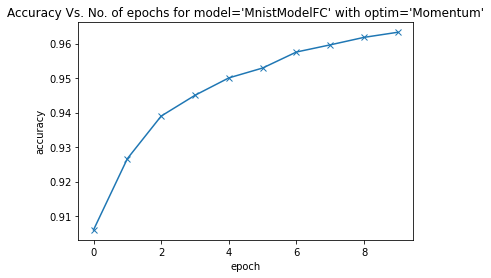

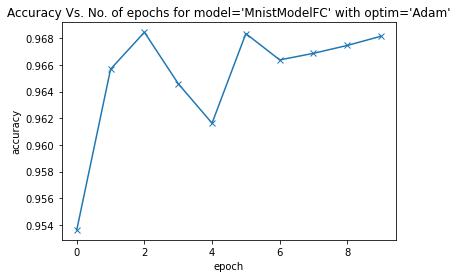

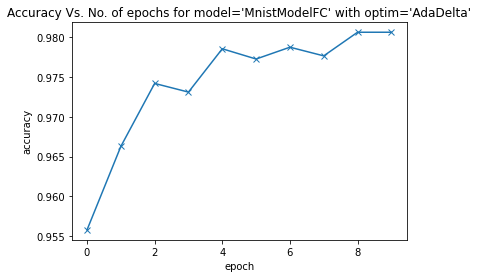

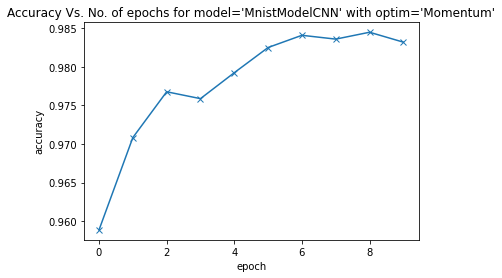

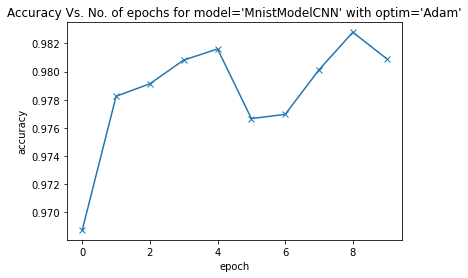

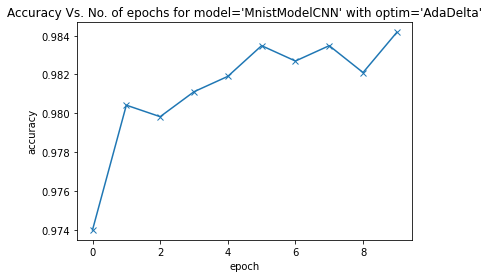

In [119]:
for name, history in hist.items():
    model, optim = name.split("_")
    accuracies = [result['val_acc'] for result in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(f'Accuracy Vs. No. of epochs for {model=} with {optim=}') 
    plt.show()

### Результаты

Пришлось увеличить количество эпох до 400 (в искусственном примере), т.к AdaDelta очень мучительно сходится. Можно попробовать добавить константный lr (в алгоритме он есть, но по умолчанию стоит 1.0), но тогда это отбрасывает всё преимущество метода - отсутствие подбора lr.
Но по результатам обучений видно, что с данным методом большие сети сходятся к лучшим значениям за то же количество итераций - это значит что он может улучшать стабильность и качество.
Momentum очень сильно шатается из-за накопленного градиента, Adam также шатается, но поменьше и сходимость у него быстрее. AdaDelta сходится дольше всего (400 sic! эпох)